In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from kneed import KneeLocator

[0.00058512 0.00039364 0.00063348 0.00054135]


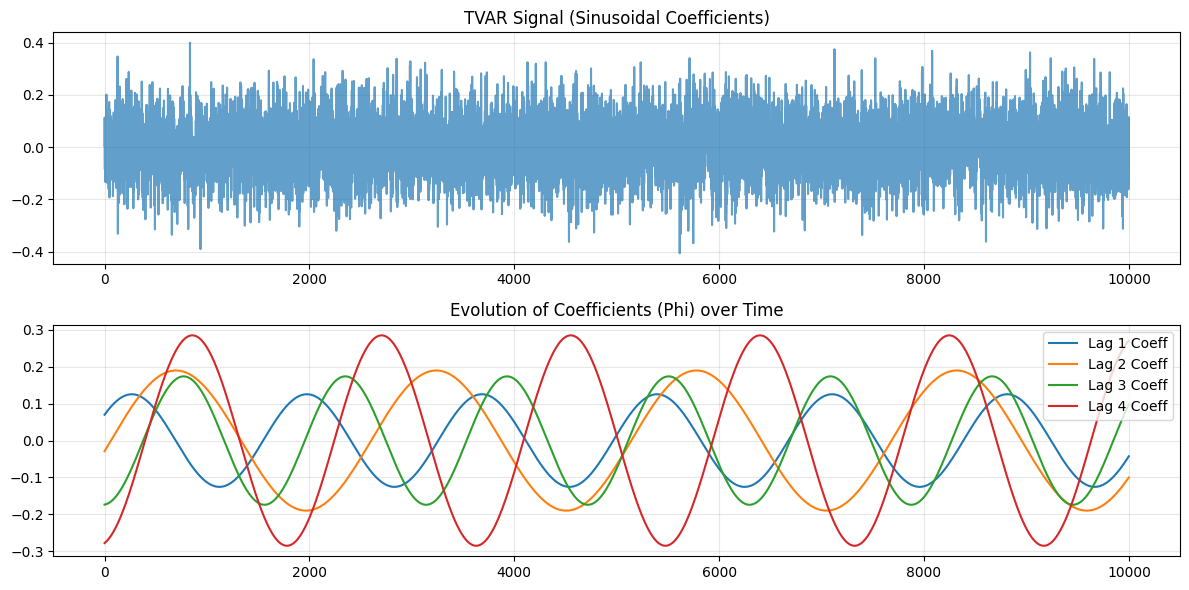

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generate_sinusoidal_tvar(n=6000, p=3, noise_std=0.1, seed=42):
    """
    Generates TVAR data where coefficients evolve according to sine waves.
    Each lag coefficient phi_i(t) has its own frequency and phase.
    """
    rng = np.random.default_rng(seed)

    # 1. Define Time
    t_arr = np.arange(n)
    
    # 2. Define the Family of Functions (Sinusoids)
    # We generate random parameters for the sine waves for EACH lag (p)
    # phi_i(t) = scale * sin(freq * t + phase)
    
    # Random frequencies between 0.001 and 0.005 (slow evolution)
    freqs = rng.uniform(0.001, 0.005, size=p) / 7
    print(freqs)
    phases = rng.uniform(0, 2*np.pi, size=p)
    
    # Scale determines how strong the coefficient is.
    # kept small (0.1 to 0.3) to prevent instability
    scales = rng.uniform(0.1, 0.3, size=p) 
    
    # Initialize coefficient matrix (n, p)
    a_time = np.zeros((n, p))
    
    for i in range(p):
        # Apply the function: A * sin(wt + phi)
        # We explicitly calculate the curve for the entire duration
        a_time[:, i] = scales[i] * np.sin(2 * np.pi * freqs[i] * t_arr + phases[i])
    
    # 3. Simulation Loop (Standard AR generation)
    x = np.zeros(n)
    eps = rng.normal(0.0, noise_std, size=n)
    
    # Init first p samples
    x[:p] = eps[:p]
    
    for t in range(p, n):
        lags = x[t-p:t][::-1]
        
        # Dot product of CURRENT coefficients with past values
        x[t] = np.dot(a_time[t], lags) + eps[t]
        
        # Stability check
        if np.abs(x[t]) > 1000:
            print(f"Signal exploded at t={t}")
            break
            
    return x, a_time, t_arr

# --- Generate and Visualize ---
x, a_true, t = generate_sinusoidal_tvar(n=10000, p=4)

plt.figure(figsize=(12, 6))

# Plot 1: The Generated Signal
plt.subplot(2, 1, 1)
plt.plot(t, x, alpha=0.7)
plt.title("TVAR Signal (Sinusoidal Coefficients)")
plt.grid(True, alpha=0.3)

# Plot 2: The Underlying Coefficients (The "Hidden" Truth)
plt.subplot(2, 1, 2)
for i in range(a_true.shape[1]):
    plt.plot(t, a_true[:, i], label=f'Lag {i+1} Coeff')
plt.title("Evolution of Coefficients (Phi) over Time")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Make Lagged Dataset

def make_lags(x, p):
    """Create lagged features: X = [x(t-1), ..., x(t-p)], y = x(t)"""
    X = np.stack([x[p-k:len(x)-k] for k in range(1, p+1)], axis=1)
    y = x[p:]
    return X, y

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class MLPTVAR(nn.Module):
    """
    Hyper-AR:
      input  z_t = [x_{t-1}, ..., x_{t-pmax}]
      output a_t = [a_1(t), ..., a_pmax(t)] and bias b_t
      prediction: xhat_t = a_t^T z_t + b_t
    """
    def __init__(self, p_max, hidden=128, depth=3, dropout=0.1):
        super().__init__()
        layers = []
        in_dim = p_max
        for _ in range(depth):
            layers.append(nn.Linear(in_dim, hidden))
            layers.append(nn.GELU())
            layers.append(nn.LayerNorm(hidden))
            layers.append(nn.Dropout(dropout))
            in_dim = hidden
        self.backbone = nn.Sequential(*layers)

        # Output both coefficients and bias: [a_1..a_pmax, b]
        self.head = nn.Linear(hidden, p_max + 1)
        self.p_max = p_max

    def forward(self, Z):
        h = self.backbone(Z)
        out = self.head(h)                           # [B, p_max+1]
        coeffs = out[:, :self.p_max]                 # [B, p_max]
        bias   = out[:, self.p_max:]                 # [B, 1]
        pred   = (coeffs * Z).sum(dim=1, keepdim=True) + bias
        return pred.squeeze(1), coeffs, bias.squeeze(1)


In [5]:
def train_tvar(
    X_tr, y_tr, X_val, y_val,
    p_max,
    hidden=128, depth=3, dropout=0.05,
    epochs=300, lr=2e-3,
    batch_size=256,
    eval_every=10,
    patience=20,  # NEW: Stop if no improvement for this many eval checks
    min_delta=1e-6,  # NEW: Minimum change to qualify as improvement
    l1_lambda=1e-5,  # NEW: L1 regularization strength
    seed=0,
):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    torch.manual_seed(seed)

    # Ensure 1D targets
    y_tr = np.asarray(y_tr).reshape(-1)
    y_val = np.asarray(y_val).reshape(-1)

    # Standardize using TRAIN only
    X_mean = X_tr.mean(axis=0, keepdims=True)
    X_std  = X_tr.std(axis=0, keepdims=True) + 1e-8
    y_mean = y_tr.mean()
    y_std  = y_tr.std() + 1e-8

    X_tr_s  = (X_tr  - X_mean) / X_std
    X_val_s = (X_val - X_mean) / X_std
    y_tr_s  = (y_tr  - y_mean) / y_std
    y_val_s = (y_val - y_mean) / y_std

    X_tr_t  = torch.tensor(X_tr_s,  dtype=torch.float32, device=device)
    y_tr_t  = torch.tensor(y_tr_s,  dtype=torch.float32, device=device)
    X_val_t = torch.tensor(X_val_s, dtype=torch.float32, device=device)
    y_val_t = torch.tensor(y_val_s, dtype=torch.float32, device=device)

    train_loader = DataLoader(
        TensorDataset(X_tr_t, y_tr_t),
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
    )

    model = MLPTVAR(p_max=p_max, hidden=hidden, depth=depth, dropout=dropout).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    best_val = float("inf")
    best_state = None
    patience_counter = 0  # NEW: Track epochs without improvement

    T = X_tr_t.shape[0]
    if T < batch_size:
        raise ValueError(f"Training set too small (T={T}) for batch_size={batch_size}")

    rng = np.random.default_rng(seed)

    for ep in range(1, epochs + 1):
        model.train()
        train_losses = []

        for Xb, yb in train_loader:
            pred, coeffs, _ = model(Xb)
            mse_loss = torch.mean((pred - yb) ** 2)
            
            # Compute L1 regularization (sum of absolute values of all parameters)
            l1_loss = torch.tensor(0., device=device)
            for param in model.parameters():
                l1_loss += torch.sum(torch.abs(param))
            
            # Total loss = MSE + L1 regularization
            loss = mse_loss + l1_lambda * l1_loss

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_losses.append(mse_loss.item())  # Track MSE for monitoring

        if (ep == 1) or (ep % eval_every == 0):
            model.eval()
            with torch.no_grad():
                pred_v, _, _ = model(X_val_t)
                val_mse = torch.mean((pred_v - y_val_t) ** 2).item()

            avg_train = float(np.mean(train_losses)) if train_losses else float("nan")

            # Check for improvement
            if val_mse < (best_val - min_delta):
                best_val = val_mse
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                patience_counter = 0  # Reset counter on improvement
                print(f"epoch {ep:04d} | train_mse {avg_train:.6f} | val_mse {val_mse:.6f} *")
            else:
                patience_counter += 1
                print(f"epoch {ep:04d} | train_mse {avg_train:.6f} | val_mse {val_mse:.6f}")
            
            # Early stopping check
            if patience_counter >= patience:
                print(f"Early stopping at epoch {ep} (no improvement for {patience} checks)")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val, (X_mean, X_std, y_mean, y_std)

In [6]:
# Build once at the maximum order so all p share the same timeline/split
p_max_global = 20
X_full, y_full = make_lags(x, p_max_global)

n_total = len(X_full)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)

idx_tr = slice(0, n_train)
idx_va = slice(n_train, n_train + n_val)
idx_te = slice(n_train + n_val, n_total)

# Train one MLP per p value
p_range = range(1, p_max_global + 1)
results = {}

for p in p_range:
    print(f"\n{'='*60}")
    print(f"Training model with p={p}")
    print(f"{'='*60}")

    # Use the SAME samples for all p; only change how many lag columns we keep
    Xp = X_full[:, :p]
    yp = y_full

    X_train, y_train = Xp[idx_tr], yp[idx_tr]
    X_val,   y_val   = Xp[idx_va], yp[idx_va]
    X_test,  y_test  = Xp[idx_te], yp[idx_te]

    model, val_loss, norm_params = train_tvar(
        X_train, y_train, X_val, y_val,
        p_max=p,
        hidden=64,
        depth=2,
        dropout=0.2,
        lr=1e-3,
        epochs=300,  # Maximum epochs (will stop early if converged)
        batch_size=64,
        eval_every=5,  # Check validation more frequently
        patience=15,  # Stop if no improvement for 15 checks (75 epochs)
        min_delta=1e-6,  # Minimum improvement threshold
        l1_lambda=1e-5,  # L1 regularization strength
        seed=42
    )

    X_mean, X_std, y_mean, y_std = norm_params
    results[p] = {
        "model": model,
        "val_loss": val_loss,
        "X_te": X_test,
        "y_te": y_test,
        "X_mean": X_mean,
        "X_std": X_std,
        "y_mean": y_mean,
        "y_std": y_std,
        # store these so downstream alignment is correct
        "p_max_global": p_max_global,
        "n_train": n_train,
        "n_val": n_val,
    }

    print(f"Completed p={p}: val_loss={val_loss:.6f}")

print(f"\n{'='*60}")
print("Training complete for all p values!")
print(f"{'='*60}")


Training model with p=1
epoch 0001 | train_mse 1.165304 | val_mse 1.023059 *
epoch 0005 | train_mse 1.018724 | val_mse 1.032345
epoch 0010 | train_mse 1.008908 | val_mse 1.025456
epoch 0015 | train_mse 1.005775 | val_mse 1.023471
epoch 0020 | train_mse 1.004952 | val_mse 1.017557 *
epoch 0025 | train_mse 1.004213 | val_mse 1.015648 *
epoch 0030 | train_mse 1.002654 | val_mse 1.015303 *
epoch 0035 | train_mse 1.002677 | val_mse 1.014061 *
epoch 0040 | train_mse 1.003006 | val_mse 1.013507 *
epoch 0045 | train_mse 1.002181 | val_mse 1.014730
epoch 0050 | train_mse 1.002361 | val_mse 1.012827 *
epoch 0055 | train_mse 1.002049 | val_mse 1.014572
epoch 0060 | train_mse 1.002204 | val_mse 1.013873
epoch 0065 | train_mse 1.001624 | val_mse 1.013993
epoch 0070 | train_mse 1.001443 | val_mse 1.015044
epoch 0075 | train_mse 1.001758 | val_mse 1.014096
epoch 0080 | train_mse 1.002119 | val_mse 1.013306
epoch 0085 | train_mse 1.001862 | val_mse 1.014665
epoch 0090 | train_mse 1.001748 | val_mse 1

Selected p = 9
Selected model val loss = 0.999733


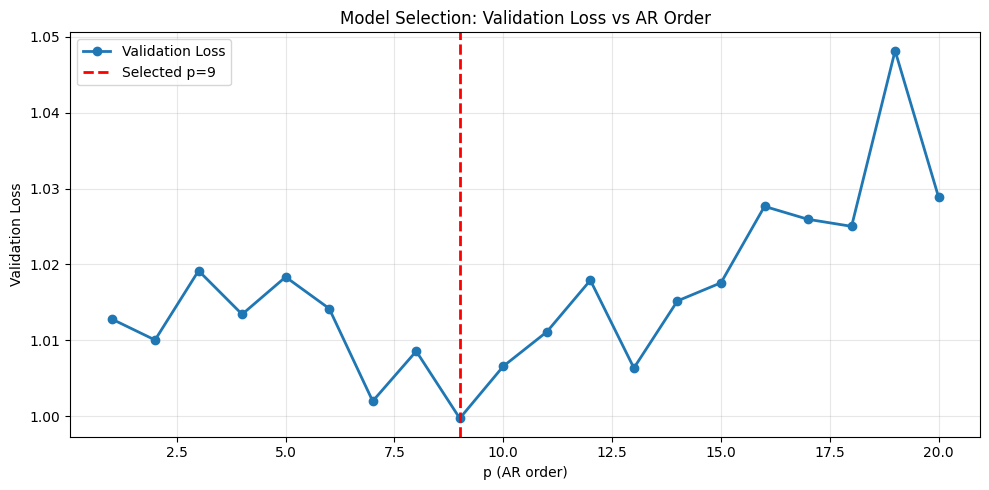

In [7]:
# Collect validation losses
val_losses = np.array([results[p]['val_loss'] for p in p_range], dtype=float)

# Choose p with lowest validation loss
p_best = list(p_range)[int(np.argmin(val_losses))]

print(f"Selected p = {p_best}")
print(f"Selected model val loss = {results[p_best]['val_loss']:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(list(p_range), val_losses, 'o-', linewidth=2, markersize=6, label='Validation Loss')
plt.axvline(p_best, color='red', linestyle='--', linewidth=2, label=f'Selected p={p_best}')
plt.xlabel('p (AR order)')
plt.ylabel('Validation Loss')
plt.title('Model Selection: Validation Loss vs AR Order')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Test Set Evaluation (p=9)
Test MSE: 0.012032
Test RMSE: 0.109691
Test samples: 998



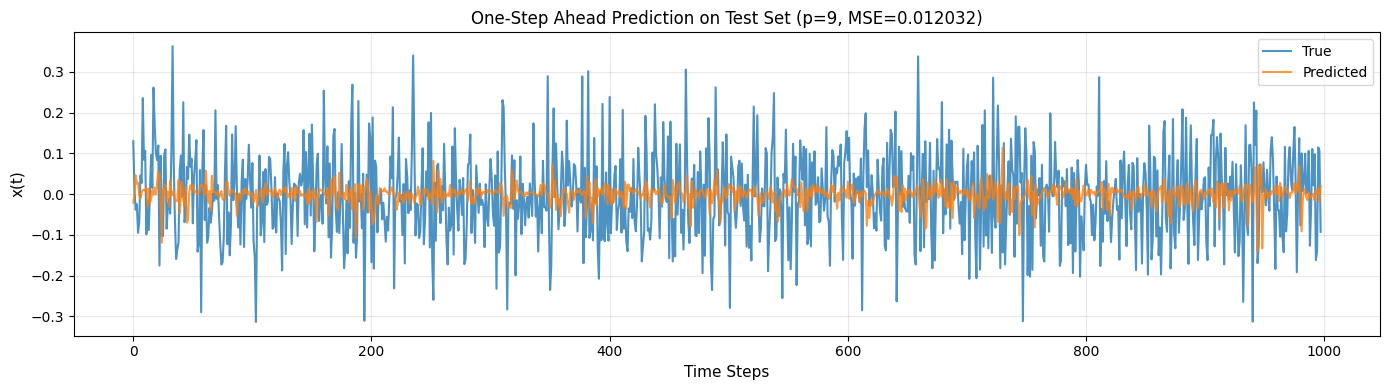

In [8]:
# Extract coefficients and predictions on test data
r = results[p_best]
device = "cuda" if torch.cuda.is_available() else "cpu"

# Standardize test data using training statistics
X_te_s = (r['X_te'] - r['X_mean']) / r['X_std']
X_te_t = torch.tensor(X_te_s, dtype=torch.float32).to(device)

# Get predictions and learned coefficients
r['model'].eval()
with torch.no_grad():
    y_pred_s, coeffs_s, bias_s = r['model'](X_te_t)
    y_pred = y_pred_s.cpu().numpy() * r['y_std'] + r['y_mean']
    learned_coeffs = coeffs_s.cpu().numpy() * r['y_std'] / r['X_std'].flatten()
    learned_bias = bias_s.cpu().numpy() * r['y_std'] + r['y_mean']

# Compute test MSE
test_mse = np.mean((r['y_te'] - y_pred) ** 2)
print(f"\n{'='*60}")
print(f"Test Set Evaluation (p={p_best})")
print(f"{'='*60}")
print(f"Test MSE: {test_mse:.6f}")
print(f"Test RMSE: {np.sqrt(test_mse):.6f}")
print(f"Test samples: {len(y_pred)}")
print(f"{'='*60}\n")

# Plot predictions - show first 1000 samples
plt.figure(figsize=(14, 4))
n_plot = min(1000, len(y_pred))
t_plot = np.arange(n_plot)

plt.plot(t_plot, r['y_te'][:n_plot], label='True', linewidth=1.5, alpha=0.8)
plt.plot(t_plot, y_pred[:n_plot], label='Predicted', linewidth=1.5, alpha=0.8)
plt.xlabel('Time Steps', fontsize=11)
plt.ylabel('x(t)', fontsize=11)
plt.title(f'One-Step Ahead Prediction on Test Set (p={p_best}, MSE={test_mse:.6f})', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Coefficient Alignment:
True p: 3
Selected p: 9
Test samples: 998
True coefficients shape: (998, 4)
Learned coefficients shape: (998, 9)



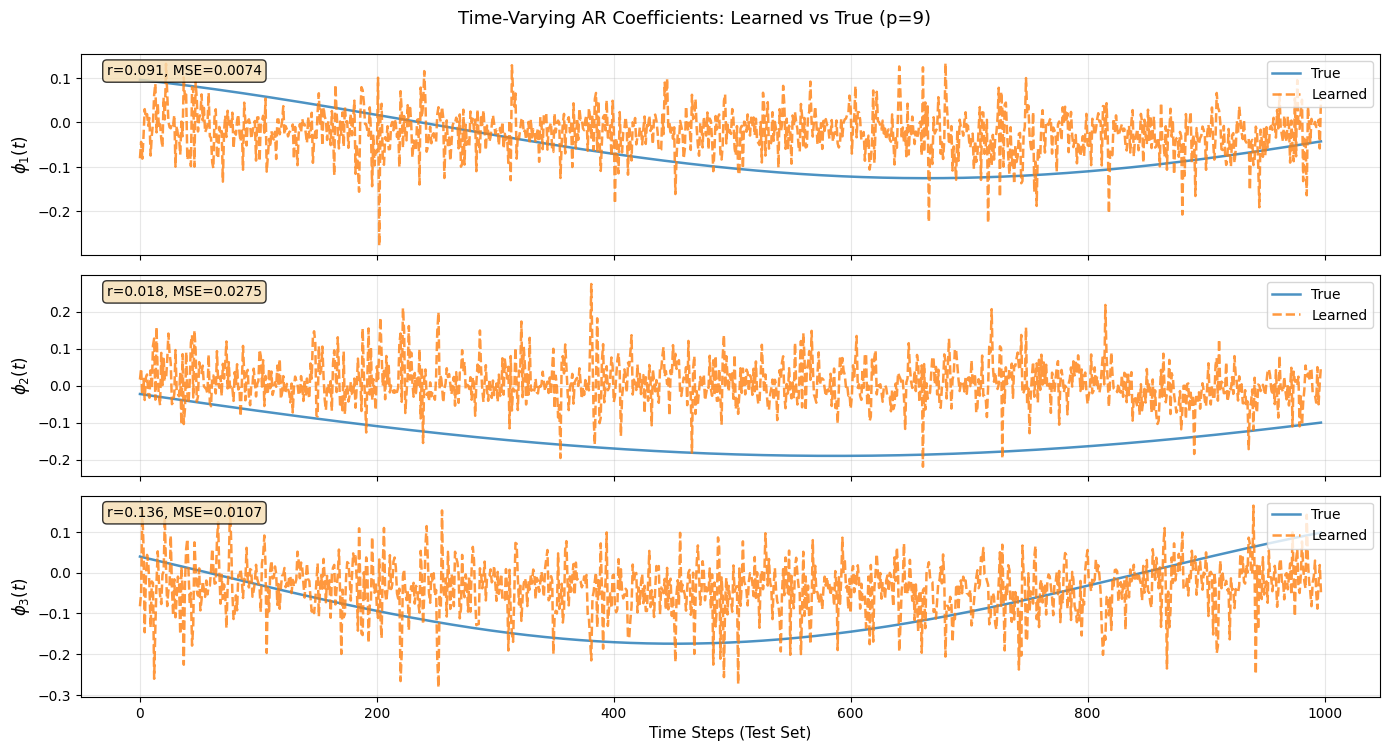


Coefficient Recovery Statistics:
Lag 1: Correlation=0.0912, MSE=0.007380
Lag 2: Correlation=0.0179, MSE=0.027493
Lag 3: Correlation=0.1359, MSE=0.010656



In [9]:
# Compare learned coefficients with true coefficients

# Align true coefficients with test data time indices
# Test data starts at index: p_best + n_train + n_val
# Align true coefficients with test data time indices
r = results[p_best]
p_max_global = r["p_max_global"]
n_train = r["n_train"]
n_val = r["n_val"]

# y_full corresponds to x[p_max_global:], so test starts at:
test_start_idx = p_max_global + n_train + n_val

a_true_test = a_true[test_start_idx:test_start_idx + len(learned_coeffs), :]

print(f"\nCoefficient Alignment:")
print(f"True p: 3")
print(f"Selected p: {p_best}")
print(f"Test samples: {len(learned_coeffs)}")
print(f"True coefficients shape: {a_true_test.shape}")
print(f"Learned coefficients shape: {learned_coeffs.shape}\n")

# Plot learned vs true coefficients
p_true = 3  # From the data generation
n_lags_plot = min(p_best, p_true)  # Only plot up to true p for meaningful comparison

fig, axes = plt.subplots(n_lags_plot, 1, figsize=(14, 2.5*n_lags_plot), sharex=True)
if n_lags_plot == 1:
    axes = [axes]

t_test = np.arange(len(learned_coeffs))
n_plot = min(2000, len(learned_coeffs))  # Plot first 2000 points

for i in range(n_lags_plot):
    # Plot true coefficient
    axes[i].plot(t_test[:n_plot], a_true_test[:n_plot, i], 
                label='True', linewidth=1.8, alpha=0.8, color='C0')
    
    # Plot learned coefficient
    axes[i].plot(t_test[:n_plot], learned_coeffs[:n_plot, i], 
                label='Learned', linewidth=1.8, linestyle='--', alpha=0.8, color='C1')
    
    # Calculate correlation and MSE
    corr = np.corrcoef(learned_coeffs[:, i], a_true_test[:, i])[0, 1]
    mse_coeff = np.mean((learned_coeffs[:, i] - a_true_test[:, i]) ** 2)
    
    # Display metrics
    axes[i].text(0.02, 0.95, f'r={corr:.3f}, MSE={mse_coeff:.4f}', 
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                fontsize=10)
    
    axes[i].set_ylabel(f'$\\phi_{{{i+1}}}(t)$', fontsize=12)
    axes[i].legend(loc='upper right', fontsize=10)
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time Steps (Test Set)', fontsize=11)
plt.suptitle(f'Time-Varying AR Coefficients: Learned vs True (p={p_best})', 
             fontsize=13, y=0.995)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nCoefficient Recovery Statistics:")
print(f"{'='*60}")
for i in range(n_lags_plot):
    corr = np.corrcoef(learned_coeffs[:, i], a_true_test[:, i])[0, 1]
    mse = np.mean((learned_coeffs[:, i] - a_true_test[:, i]) ** 2)
    print(f"Lag {i+1}: Correlation={corr:.4f}, MSE={mse:.6f}")
print(f"{'='*60}\n")